## FILL IN YOUR NAME AND UTORID HERE

# Determining orbital and physical parameters from eclipsing binaries#

==========================================================

## Before you begin

Assuming you have loaded this file into your Jupyter Notebooks workspace, make sure to press the "play" button at the top of the page in each box. This will render the Markdown into nicely-formatted text and execute all of the sections of Python code. Note that some sections will give error messages until you add the calculations you are asked for. 

As you modify each of the following segments of code, remember to hit the "play" button at the top of the notebooks interface so that the cell containing the code "runs" (you can also hit Shift+Return for the same functionality). It should display the output of the piece of code just below that cell. You can run every cell in this notebook before you modify it, just to see what it produces. If you find any of this confusing or overwhelming, please refer back to the programming resources in the "Guides" section on Quercus. The "Introduction to Programming" guide contains links to some documents that should help you.

For this project, you are asked to put your results together in a report that you will submit that includes some of the figures generated below (as indicated in the code blocks), results for each section in tables, and answers to the highlighted questions. Please see the instructions for more information. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

## 1. Determining the transit period ##

As noted in the Instructions, you have been assigned light curves from **two** different eclipsing binary pairs that have been observed with NASA's Kepler space telescope. These light curves have had several corrections applied to account for various instrumental and other effects in the data. Kepler data can contain a series of systematic trends associated with the spacecraft, detector and environment rather than the target. As a result, you will be working with measurements of the normalized flux, where outside of the transit events the normalized flux is approximately 1. For the analysis you will do, the flux units are not important, and the normalization will help you find the period much more easily than in the uncorrected data. 

The first step is to read in your assigned light curve and radial velocity datasets. Download these files from the project page, and make sure you grab the correct files for the binary pairs you are assigned! Based on how we have set up this template, it's a good idea to work on your binary pairs one at a time. I recommend doing your analysis in two separate notebooks - one for each pair. 

It's a good idea to take a look at the files in a text editor or in your syzygy folder before you go ahead with the first step below. The Kepler transit data files contain seven columns of numbers. The first is the time measurement - in this case, the Barycentric Julian Date (BJD). This is the Julian Date corrected for differences in the Earth's position with respect to the barycentre of the Solar System. The next six columns contain different flux measurements and their uncertainties. You are welcome to look at the differences between the values! The `raw_flux` and `corr_flux` (and their associated `err` columns) contain Kepler flux measurements prior to some of the calibrations. We will be primarily working with the `dtr_flux` column (detrended flux), which has applied corrections and removed the longer timescale trends mentioned above in the measured flux that are not due to the binary star transits. 

The radial velocity (RV) datasets contain nine columns, of which we'll read in eight. The important columns are the observation date, the corresponding phase of the orbit at the observation time (discussed further below), and the measured radial velocities (and measurement uncertainties) for star 1 and star 2 (`Primary Vrad` and `Primary Vrad err`, `Secondary Vrad` and `Secondary Vrad err`). 

In [2]:
#Read in Kepler dataset. Enter the file name of the Kepler data set you were assigned.
bjd, raw, rawerr, corr, correrr, dtr, dtrerr = np.loadtxt('000.lc.data',skiprows=1,unpack=True)

#Read in RV dataset. Enter the file name of the RV data set corresponding to the above Kepler data.
date, phase_v, rv1, rv1err, oc1, rv2, rv2err, oc2 = np.loadtxt('000_rv.txt',unpack=True,dtype=None, usecols=(0,1,2,3,4,5,6,7))

Text(0.5, 1.0, 'Detrended data')

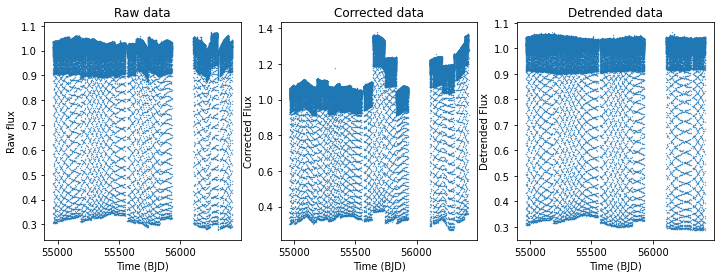

In [3]:
%matplotlib inline

#Plot the data. Here we have set up a three-panel plot so you can look at the effects of the different calibrations
# on the data. Be sure to include labels on your axes, and titles on your plots to show which panel is showing
# which data column! You may want to adjust the size of the plot markers to better see trends in the data. 

fig = plt.figure(figsize=(12,4))

# Plot the raw data (flux vs. time):
ax1 = plt.subplot(131)
ax1.scatter(bjd, raw, s=0.1)
# Include labels & titles
ax1.set_ylabel('Raw flux')
ax1.set_xlabel('Time (BJD)')
ax1.set_title('Raw data')

# Plot the corrected data, labels & titles:
ax2 = plt.subplot(132)
ax2.scatter(bjd, corr, s=0.1)
ax2.set_ylabel('Corrected Flux')
ax2.set_xlabel('Time (BJD)')
ax2.set_title('Corrected data')
# Plot the detrended data, labels & titles:
ax3 = plt.subplot(133)
ax3.scatter(bjd, dtr, s=0.1)
ax3.set_ylabel('Detrended Flux')
ax3.set_xlabel('Time (BJD)')
ax3.set_title('Detrended data')

It might be immediately clear from the previous plots that there are some periodic variations in the data! Kepler has observed these stars many times over a long timescale, so you are actually seeing datapoints from many transits here. If your plots just look like solid colour, try changing the point size to a smaller value (i.e., `s=1` or `s=0.5` in the `scatter` function). To better see what one of these transits looks like, below you should select a smaller range in time and look at the detrended data specifically. You may need to use some trial and error to select a range in time that shows a small sample of transits. 

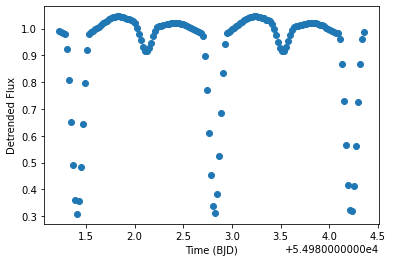

In [4]:
# Try zooming in to look at only a few transits as a function of time. Change the range of values that you plot 
# to see more or less of the data.
# Recall from a previous assignment that you can select a subset of an array (i.e., between indices x1 and x2)
# using the syntax array[x1:x2]. So to plot a range in the arrays, you can use plt.scatter(array1[x1:x2],array2[x1:x2])
# Make sure you use the same x1, x2 for both your x and y axes in your plot, or the numbers won't match and python
# will complain. 
# Use this to estimate a period for use in the next step.

# Choose a range of indices to plot:
x1 = 812
x2 = 965

# Plot, with labels! 
fig = plt.figure()
plt.scatter(bjd[x1:x2],dtr[x1:x2])
plt.xlabel('Time (BJD)')
plt.ylabel('Detrended Flux')

# Plot 1.1 - include this in your report. 
# When you are happy with your plot, uncomment the next line, change the filename to something useful, and save 
# you plot to a file:
plt.savefig('Transits_0.png')

With only a few transits, you might be able to eyeball this plot and get a rough idea of the period for your binary system. (These datasets have very strong transits, but most Kepler datasets - especially where the transits are due to planets orbiting rather than stars, are not nearly so obvious!) For your analysis, though, we will need a very precise orbital period. 

We will get a more precise measurement of the period if we can use all the measured data. To do this, we *fold* the data around an initial estimate of the period, such that the date and time measurement is converted to some fraction of the orbital period - this is called the phase. As an example, if we have measurements on days 1, 2, 3, and 4, and the orbital period is 3, then the phase of the measurements would be 1/3, 2/3, 3/3, and 4/3. The observations on days 1 and 4 therefore track the same part of the binary orbit, and we can combine these data points to obtain a better measure of the normalized flux, and hence the light curve over the binary period. 

If we get the period just right, the light curves over the entire set of observations should line up nicely to provide a single light curve with clear transits. The accuracy needed makes this a little challenging. Below, we've written a short loop that will go through a range in periods that you select, based on your initial guess above, and will calculate how much the datapoints at each individual phase vary from each other using a standard deviation calculation. If you think about the phase, when we get the period right, the datapoints at a particular phase in the orbit should have the least variation from one another. When the period is wrong, the datapoints will vary a lot. 

In [5]:
#Here we will test a large number of periods to find the best fit to the data. 
#We use python's mod function (%) to fold the date data into proposed phase.
#This returns the remainder after one value is divided by another. Think about 
#why this works and returns the value we want! 

#Set up an array with a range of periods that you want to test,centered near
#your estimate of the period from the previous step. The arguments for numpy's
#linspace function are (start, stop, number of steps). You may need to use some
#trial and error to figure out what range of periods you need to test, and how
#finely you should sample that range. 
period_range=np.linspace(0.70175, 0.7029, 1000)

# This is an array where we will store the standard deviation results for each 
# tested period. It has the same size as the period_range array above, so we
# can match the period with the scatter and identify for which period the scatter
# is minimized. 
scatter=np.empty(len(period_range))

#Loop through the range of estimated periods:
for i in range(len(period_range)):
    
    #Calculate the phase at the given period and choose data point within
    #a small phase range
    #This phase range should work for most of you, but if you are finding
    #that this loop is not producing an obvious minumium, you can try 
    #adjusting it.
    phase=(bjd/period_range[i])%1
    phase_range=np.where((phase>0.75) & (phase<0.95))
    
    #Calculate the scatter in the detrended flux of these data points
    scatter[i]=np.std(dtr[phase_range])

Best fit period: 0.70236 days


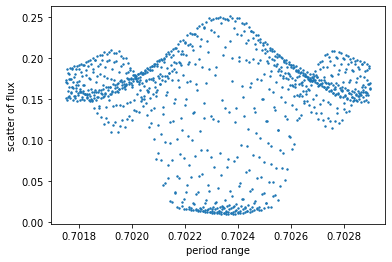

In [6]:
#Plot the scatter as a function of the test periods. Include appropriate axis labels.
#You will likely need to iterate on this step and the previous one, to find your best period. 
plt.figure()
plt.scatter(period_range,scatter,s=2.0)
plt.xlabel('period range')
plt.ylabel('scatter of flux')


#The period with the smallest scatter will be closest to the period we want
min_scatter=np.where(scatter==np.min(scatter))
print('Best fit period:',round(period_range[min_scatter][0],5),'days')

# Plot 1.2 - include this in your report
# When you are happy with your plot, uncomment the next line, change the filename to something useful, and save 
# you plot to a file:
plt.savefig('scatter_phase_plot_0.png')

Text(0, 0.5, 'Detrended flux')

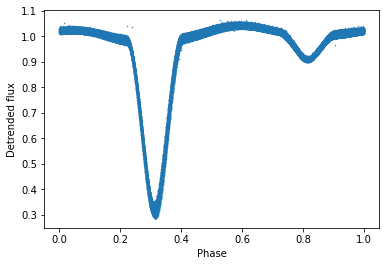

In [7]:
#The best fit period that you found in the previous step is likely not a perfect
#fit to the period. Calculate the phase using this period and plot the data to see
#how close you are. Then use trial and error until you feel like you have the best 
#estimate of the period. Ideally, the data will stack in such a way that you will 
#only see two transits when you have a very close estimate of the period.

# You will likely find your best fit with the period set to at least 4 or 5 decimal
# places. Be careful with this step - a small error in the period will lead to much
# larger errors in your calculations of the binary masses, and will make it hard to
# determine the transit timings. 

period = 1.40469 # Set your period value here, update and iterate as necessary
myphase = (bjd % period)/period

# Plot the detrended flux vs. phase with labels!
fig = plt.figure()
plt.scatter(myphase, dtr, s=0.2)
plt.xlabel('Phase')
plt.ylabel('Detrended flux')

# Plot 1.3 - include this in your report
# When you are happy with your plot, uncomment the next line, change the filename to something useful, and save 
# you plot to a file:
#plt.savefig('phase_plot_0.png')

### Question 1.1 ###
In your report, include a table that lists: 
- your initial period estimate from the scatter phase plot
- your final period estimate
- an estimate of your uncertainty in your orbital period result. I.e., at what precision can you change the period and not change the resulting scatter in your data points? 

## 2. Fitting the radial velocities ##

Radial velocity information is determined by fitting the absorption lines in the observed spectra as a function of time. Due to the motions of the stars in their orbits, the wavelengths at which these lines are observed will shift periodically. (See the example image in the project description!) In practice, this will generally involve using a template of multiple lines typically seen in the type of star being observed, in order to determine which lines are from which star in the binary pair. You will not do this analysis here, but we have given you the results of this analysis in the RV (radial velocity) dataset (see the notes on the RV columns above). 

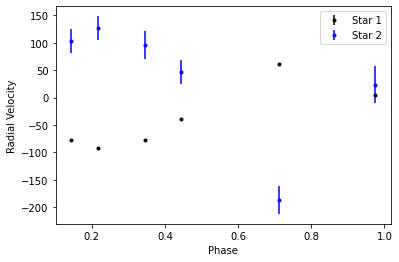

In [8]:
#First, plot the RV data, removing points where the RV or the error is 0.0.
#(Remind yourself from the discussion above what your arrays are named!)
#The where function returns positions in an array that match the conditions
#it has been given. In this case, we are searching for where the RV data or
#associated uncertainties are not 0. The operator "!=" means "not equal to". 
#The RV data have already had their dates converted to an orbital phase. 
good1 = np.where((rv1 != 0) & (rv1err != 0))
good2 = np.where((rv2 != 0) & (rv2err != 0))

plt.figure()
# Use the plt.errorbar() function here. The syntax is plt.errorbar(x,y,yerr=yerr,fmt='.'), 
# where x and y are your arrays for your x and y axes, and yerr is your array for the 
# measurement uncertainty in y. fmt = '.' plots your data as points, but there are different
# marker styles you can use if you like. 
# Here, we want to plot the phase along the x-axis, rather than the date of the observations. In this
# dataset, the binary period has been determined and the phase of the observations has been calculated already.
# To include only the good points as defined above, use phase_v[good1], rv1[good1], and rv1err[good1] in
# your plot call. Do the same for rv2. This will only plot the array values at those indices in 'good1'. 
# Use different colours for your two stars (set colours using color='red' or other named colours in 
# the plt.errorbar() call). Add a label (label = 'star 1', e.g.), and a legend (plt.legend()). 
plt.errorbar(phase_v[good1], rv1[good1], yerr=rv1err[good1], fmt='.', color='black')
plt.errorbar(phase_v[good2], rv2[good2], yerr=rv2err[good2], fmt='.', color='blue')
plt.ylabel('Radial Velocity')
plt.xlabel('Phase')
plt.legend(['Star 1', 'Star 2'])

The variation in the radial velocity measurements for each star depends on their masses and orbital parameters. Go back to C&O or do some additional reading if you are unsure about what you are looking at in this plot! Here, we will attempt to estimate the maximum radial velocities for each star by creating a sine curve model with estimated amplitude and offset values, and compare the model curve to the data points. To identify quantitatively a best-fit model, calculate the reduced chi-squared statistic, and find a set of parameters that minimizes this quantity (if you have not used a chi-square statistic before, you may need to research this). By trial and error, it will not be possible to find the absolute best parameters, but you should be able to show that you have tested several parameter values and that your final results are better based on the chi-squared metric than others. 

Reduced chi-squared for RV1: 15.453004869265655
Reduced chi-squared for RV2: 15.751929506483291
-86.51385158536775 145.17150714604165


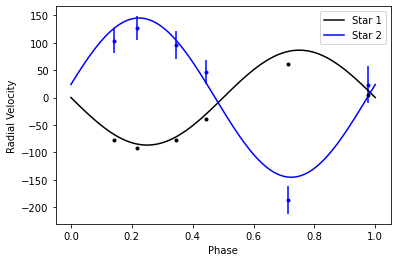

In [53]:
#Here we will fit the radial velocity data with a sine wave and an offset from zero.
#This will give is the radial velocities of the two stars as well as the systemic velocity, 
#or center of mass velocity.
#To find the best fit, calculate the reduced chi-squared statistic of the data and choose the
#velocities and offset that minimize this value.
#This will take some trial and error. If you're python-savvy, you might figure out how to use
#some of python's capabilities to find the best-fit model to each star's radial velocity data, 
#but that is not required. 

from scipy.optimize import curve_fit

def sin_fun(t, A, p):
    return A * np.sin(2*np.pi*t+p)

#Plot the RV data as in the previous step. Be sure to only plot the 'good' values. 
fig = plt.figure()
plt.errorbar(phase_v[good1], rv1[good1], yerr=rv1err[good1], fmt='.', color='black')
plt.errorbar(phase_v[good2], rv2[good2], yerr=rv2err[good2], fmt='.', color='blue')
plt.ylabel('Radial Velocity')
plt.xlabel('Phase')


#Make continuous phase array using numpy's linspace function to use in your model
#fit to the data.
phase_arr = np.linspace(0,1,100)


#Guess how offset the curves are from zero.
offsetguess = -2.

popt_1, pcov_1 = curve_fit(sin_fun, phase_v[good1], rv1[good1])
popt_2, pcov_2 = curve_fit(sin_fun, phase_v[good2], rv2[good2])

#Here we will attempt to fit the RV1 curve with a sine wave and offset.
#Estimate the maximum radial velocity of the first star from the plot of the RV data.
v1guess = 95
# Write a mathematical expression for a sine wave with your offset and estimated maximum
# radial velocity. Recall that your phase is a fraction of 2pi. 
testSin_v1 =  popt_1[0] * np.sin(2*np.pi*phase_arr+popt_1[1]) 

#Fit the RV2 curve with a sine wave and offset.
#Estimate the maximum radial velocity of the second star from the plot of the RV data.
v2guess = 150
testSin_v2 = popt_2[0] * np.sin(2*np.pi*phase_arr+popt_2[1]) 


#Plot the sine waves on top of the data. It's a good idea to match colours to your data points.
#Add labels for the legend in your final plot. 
plt.plot(phase_arr, testSin_v1, color = 'black', label = 'Star 1')
plt.plot(phase_arr, testSin_v2, color = 'blue', label = 'Star 2')
plt.legend()

#Calculate reduced chi-squared statistic for two curves. Write your own equation for the
#statistic and print the output.
N = 2
chi = []
def chi_sq(l, o, f, e):
    for i in range(l):
        chi.append(((o[i]-f[i])**2)/(e[i]**2))
        return (sum(chi)/(l-N))
red_chisq1 = chi_sq(len(phase_v[good1]), rv1[good1], sin_fun(phase_v[good1], popt_1[0], popt_1[1]), rv1err[good1])
red_chisq2 = chi_sq(len(phase_v[good2]), rv2[good2], sin_fun(phase_v[good2], popt_2[0], popt_2[1]), rv2err[good2])
print('Reduced chi-squared for RV1:', red_chisq1)
print('Reduced chi-squared for RV2:', red_chisq2)

# Plot 2.1 - include this in your report
# When you're happy with your result, uncomment the line below, change your plot name to something useful, 
# and save your plot
plt.savefig('sin_curve_model_000.png')
print(popt_1[0], popt_2[0])

### Question 2.1 ###
Describe your method for estimating the offsets and the amplitude of the radial velocity curves, and show your mathematical expression for the sine wave. Include a table that lists a range of parameters you tried, and what the reduced chi-squared statistics were for each (if you tried a lot of parameters, list a representative range of ~3 maximum radial velocity values for each star). 

### Question 2.2 ###
Show an example calculation for the reduced chi square statistic for one of your model curves. 

### Question 2.3 ###
Estimate the uncertainty in the amplitude of the radial velocity curves for both stars. Add this to your table in 2.1. Is one measurement more accurate than the other? Why or why not?  

## 3. Measuring transit times and depths ##
You have measured the orbital period and the radial velocities of your binary stars. Congratulations! Next we will look at the transit in more detail to determine the transit times and depth. This will allow us to calculate the radii of the stars. Again, look to C&O Chapter 7 for more detail on how the transit shape can be used to determine stellar parameters. We will use a fairly simple method to estimate these transit times; if you were doing this for a research paper you would certainly use a different method to fit the light curve with a model transit based on input stellar and orbital parameters. 

Here, we will look at both the primary and secondary transits. The primary transit is the one with the greatest decrease in normalized flux over the transit. 


Text(0, 0.5, 'Detrended flux')

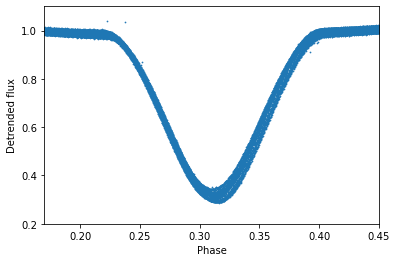

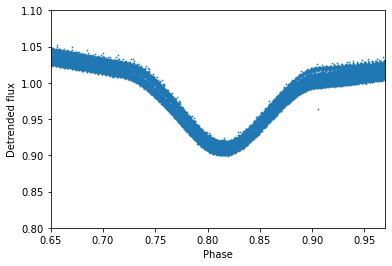

In [31]:
#Plot the Kepler data again, but zoom in on the two transits individually.
#The xlim and ylim function set the range of x and y values that will be plotted.
#Look at your previous plot of the normalized flux vs period of the folded data
#to estimate these limits.


#Set xlim (in normalized flux) and ylim ranges (in phase) for the primary (p) and secondary (s) transits.
xlim_p=[0.17,0.45]
ylim_p=[0.2,1.1]
xlim_s=[0.65,0.97]
ylim_s=[0.8,1.1]


#Plot the primary transit with labels.
fig = plt.figure()
plt.scatter(myphase, dtr, s=0.5)
plt.xlim(xlim_p[0],xlim_p[1])
plt.ylim(ylim_p[0],ylim_p[1])
plt.xlabel('Phase')
plt.ylabel('Detrended flux')
#Plot the secondary transit with labels. 
fig = plt.figure()
plt.scatter(myphase, dtr, s=0.5)
plt.xlim(xlim_s[0],xlim_s[1])
plt.ylim(ylim_s[0],ylim_s[1])
plt.xlabel('Phase')
plt.ylabel('Detrended flux')

In most cases, your transits will not have a clear, flat bottom part of the curve as you see in the examples in C&O.  The clarity of the transit shape will also depend on how well you determined your orbital period in the previous steps! Here, we will walk through a process to estimate the timings for the transit ingress and egress. 

Median primary transit depth: 28635.0 +/- 16412.28213993212


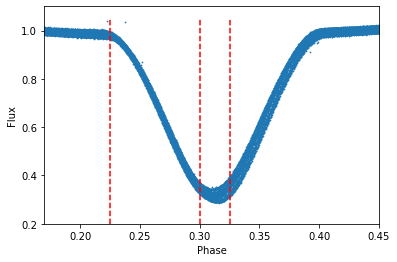

In [55]:
#Approximate the first contact (ta), beginning of miniumum light (tb), and end of
# minimum light (tc) times of the primary transit (see C&O Fig 7.9 and Eqns 7.8 and 7.9).
ta=0.225
tb=0.30
tc=0.325
# What would you estimate as the level of uncertainty in each of these times, in units of phase? 
# Keep track of that here: 
dta = 0.005
dtb = 0.01
dtc = 0.001


#Plot your primary transit as above with labels
#Plot vertical lines at ta, tb, and tc to help estimate the values.
#You will likely want to iterate on this and the previous step to find your best estimate. 
fig = plt.figure()
plt.scatter(myphase, dtr, s=0.5)
plt.xlim(xlim_p[0],xlim_p[1])
plt.ylim(ylim_p[0],ylim_p[1])
plt.vlines(x=ta,ymin=0.1,ymax=1.05,linestyles='--',color='red')
plt.vlines(x=tb,ymin=0.1,ymax=1.05,linestyles='--',color='red')
plt.vlines(x=tc,ymin=0.1,ymax=1.05,linestyles='--',color='red')
plt.xlabel('Phase')
plt.ylabel('Flux')

# Plot 3.1 - include this in your report
# When you are happy with the result, uncomment the below line, change the filename to something useful, and save
# your plot. 
plt.savefig('Primary_transit_000.png')

#Find the transit depth of the primary transit by finding the median value 
#of the data near its minimum.
#Use tb and tc to set phase range of primary transit minimum then calculate the
#median value of the data here (np.median()). Take the uncertainty in this measurement 
#as the standard deviation of the data (np.std()).
minindex1=np.where((myphase>tb) & (myphase<tc))[0]
depth1= np.median(minindex1)
depth1err= np.std(minindex1)
print('Median primary transit depth:',depth1,'+/-',depth1err)

Median secondary transit depth: 28669.0 +/- 16476.70632088513


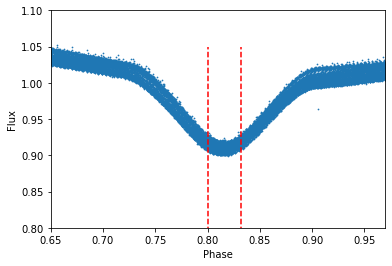

In [56]:
#Find the transit depth of the secondary transit by finding the median value 
#of the data near its minimum. Estimate a start and end time (in phase) of the 
#minimum light for this transit.
start_min=0.8
end_min=0.832

#Plot your secondary transit as above with labels
#Plot vertical lines at these times to help estimate the values.
fig = plt.figure()
plt.scatter(myphase, dtr, s=0.5)
plt.xlim(xlim_s[0],xlim_s[1])
plt.ylim(ylim_s[0],ylim_s[1])
plt.vlines(x=start_min,ymin=0.3,ymax=1.05,linestyles='--',color='red')
plt.vlines(x=end_min,ymin=0.3,ymax=1.05,linestyles='--',color='red')
plt.xlabel('Phase')
plt.ylabel('Flux')

# Plot 3.2 - include this in your report
# When you are happy with the result, uncomment the below line, change the filename to something useful, and save
# your plot. 
plt.savefig('Secondary_transit_000.png')

#Use start_min and end_min to set phase range of primary transit minimum then 
#calculate the median value of the data here (np.median()). Take the uncertainty as the 
#standard deviation of the data (np.std()).
bidindex2=np.where((myphase>start_min)&(myphase<end_min))[0]
depth2= np.median(bidindex2)
depth2err= np.std(bidindex2)
print('Median secondary transit depth:',depth2,'+/-',depth2err)

### Question 3.1 ###
Include in your report a table containing the transit times (first contact ($t_a$), beginning of miniumum light ($t_b$), and end of minimum light ($t_c$), your estimated uncertainties in these values, and the transit depths and uncertainties that you measured.  

### Question 3.2 ###
Explain why the light curves have the shapes they do. What is the cause of the lack of a flat bottom in the transits (if you see this!)?

## 4. Calculating orbital and stellar parameters! ##

Using all of the information you have obtained through the analysis of this data, you should now be able to calculate the following:
- The semi-major axis ($a$) in units of solar radii ($R_\odot$)
- The total mass of the system in units of solar mass ($M_1 + M_2$)
- The mass ratio of the stars ($M_2/M_1$)
- The individual masses of the stars in solar masses ($M_\odot$)
- The radii of both stars ($R_1$ and $R_2$) in units of solar radii
- The temperature ratio of the stars ($T_2/T_1$)

You can do your calculations in the box below if you choose. Make sure you are keeping track of units as you go. In your report, you should show your work for each calculation by giving and explaining the relevant equations in your document, including the values of the parameters you found in this analysis and use in the final calculations. Show the calculations clearly for each of the values listed above, and include a final table that lists each value. 

**Make sure you give your results in the requested units! Marks will be reduced otherwise.**

In [61]:
#Calculations
#Using all of the information you have obtained through the analysis of this data, 
#calculate the following:
v1 = -1*popt_1[0]
v2 = popt_2[0]
#3. The mass ratio of the stars (M2/M1)
m_ratio = v1/v2
print('The mass ratio of the stars is', m_ratio)
#2. The total mass of the system in units of solar mass (M1 + M2)
G = 6.67*10**(-1*11)
solar_mass = 1.9891*10**(30)
total_mass = (period/(2*np.pi*G))*(v1+v2)**3 / solar_mass
print('The total mass of the stars is', total_mass, 'solar masses')
#1. The semi-major axis (a) in units of solar radii
a = (total_mass*period**2)**(1/3)
print('The semi major axis is', a, 'km')
#4. The individual masses of the stars in solar masses
m2 = ((period/(2*np.pi*G))*v1**3 * total_mass**2)**(1/3)
m1 = total_mass - m2
m1_new = m1 * solar_mass
m2_new = m2 * solar_mass
print('The mass of star 1 is', m1_new, 'kg')
print('The mass of star 2 is', m2_new, 'kg')
#5. The radii of both stars
r_small = (v1+v2)/2 * (tb-ta)
r_large = (v1+v2)/2 * (tc-ta)
print('The radius of star 1 is', r_small, 'km')
print('The radius of star 2 is', r_large, 'km')
#6. The temperature ratio of the stars (T2/T1)
#Make sure you are keeping track of units as you go.



The mass ratio of the stars is 0.5959423669710568
The total mass of the stars is 2.0956267805220145e-14 solar masses
The semi major axis is 3.457999878773652e-05 km
The mass of star 1 is -1.957536282972765e+26 kg
The mass of star 2 is 1.957536283389606e+26 kg
The radius of star 1 is 8.68820095242785 km
The radius of star 2 is 11.58426793657047 km


### Question 4.1 ###
In this analysis, we have omitted any discussion of inclination. Do you think this is a reasonable approximation to make for these systems? Please explain why or why not. 

### Question 4.2 ###
For each of your measurements, you have been asked to estimate the uncertainty in that measurement. Which orbital or stellar parameters do you think will be most affected by the uncertainties in your measurement? For this particular parameter, can you estimate how large an uncertainty you therefore have in that final result?  How might you reduce the measurement uncertainty? 